In [17]:
# Load required libraries

In [18]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [19]:
# Load the dataset

In [23]:
df = pd.read_csv("combined_ais_dataset_fixed.csv")
timestamp_col = next((col for col in df.columns if 'time' in col.lower()), None)
df[timestamp_col] = pd.to_datetime(df[timestamp_col])
lat_col = next((col for col in df.columns if 'lat' in col.lower()), None)
lon_col = next((col for col in df.columns if 'lon' in col.lower()), None)
speed_col = next((col for col in df.columns if 'speed' in col.lower()), None)
heading_col = next((col for col in df.columns if 'heading' in col.lower()), None)


In [24]:
# Data preprocessing

In [25]:

compliance_results = []
for mmsi, group in df.groupby('MMSI'):
    group_sorted = group.sort_values(by=timestamp_col)
    time_diffs = group_sorted[timestamp_col].diff().dropna()
    long_ok = ((group[lon_col] >= 120) & (group[lon_col] <= 140)).all()
    lat_ok = ((group[lat_col] >= 20) & (group[lat_col] <= 40)).all()
    speed_ok = (group[speed_col] <= 40).all()
    heading_ok = (group[heading_col] <= 360).all()
    has_duplicate_timestamps = group_sorted.duplicated(subset=timestamp_col).any()
    has_non_hourly_intervals = (time_diffs != pd.Timedelta(hours=1)).any()
    duration_days = (group_sorted[timestamp_col].max() - group_sorted[timestamp_col].min()).days
    is_three_months = 85 <= duration_days <= 95
    fully_compliant = all([
        long_ok, lat_ok, speed_ok, heading_ok,
        not has_duplicate_timestamps,
        not has_non_hourly_intervals,
        is_three_months
    ])
    compliance_results.append({
        "MMSI": mmsi,
        "Fully Compliant": fully_compliant
    })

compliance_df = pd.DataFrame(compliance_results)
compliant_mmsis = compliance_df[compliance_df["Fully Compliant"] == True]["MMSI"]
filtered_df = df[df["MMSI"].isin(compliant_mmsis)].sort_values(by=["MMSI", timestamp_col])


In [26]:
# Split data and normalize

In [27]:

split_data = []
for mmsi, group in filtered_df.groupby("MMSI"):
    group = group.reset_index(drop=True)
    n = len(group)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)
    group["Set"] = ["Train"] * train_end + ["Val"] * (val_end - train_end) + ["Test"] * (n - val_end)
    split_data.append(group)

final_dataset = pd.concat(split_data).reset_index(drop=True)

features = [lat_col, lon_col, speed_col, heading_col]
scaler = MinMaxScaler()
train_data = final_dataset[final_dataset["Set"] == "Train"]
scaler.fit(train_data[features])
final_dataset_scaled = final_dataset.copy()
final_dataset_scaled[features] = scaler.transform(final_dataset[features])

input_features = [lat_col, lon_col, speed_col, heading_col]
output_features = [lat_col, lon_col]
sequence_length = 3


In [28]:
# Build 1D-CNN model

In [29]:

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='sigmoid', input_shape=(3, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(rate=0.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='linear'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Prepare sequences

In [31]:
sequences = { "Train": {"X": [], "Y": []}, "Val": {"X": [], "Y": []} }

for mmsi, group in final_dataset_scaled.groupby("MMSI"):
    for dataset_type in ["Train", "Val"]:
        subset = group[group["Set"] == dataset_type].reset_index(drop=True)
        for i in range(len(subset) - sequence_length):
            X_seq = subset.loc[i:i+sequence_length-1, input_features].values
            Y_target = subset.loc[i + sequence_length, output_features].values
            sequences[dataset_type]["X"].append(X_seq)
            sequences[dataset_type]["Y"].append(Y_target)

sequences["Train"]["X"] = np.array(sequences["Train"]["X"], dtype=np.float32)
sequences["Train"]["Y"] = np.array(sequences["Train"]["Y"], dtype=np.float32)
sequences["Val"]["X"] = np.array(sequences["Val"]["X"], dtype=np.float32)
sequences["Val"]["Y"] = np.array(sequences["Val"]["Y"], dtype=np.float32)

In [32]:
# Train model with early stopping

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
model.fit(
    x=sequences["Train"]["X"],
    y=sequences["Train"]["Y"],
    validation_data=(sequences["Val"]["X"], sequences["Val"]["Y"]),
    epochs=900,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1388 - mae: 0.2693 - val_loss: 0.1526 - val_mae: 0.3326
Epoch 2/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0203 - mae: 0.1110 - val_loss: 0.0274 - val_mae: 0.1477
Epoch 3/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - mae: 0.0784 - val_loss: 0.0042 - val_mae: 0.0524
Epoch 4/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - mae: 0.0605 - val_loss: 0.0031 - val_mae: 0.0475
Epoch 5/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0043 - mae: 0.0497 - val_loss: 0.0019 - val_mae: 0.0364
Epoch 6/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - mae: 0.0432 - val_loss: 0.0021 - val_mae: 0.0376
Epoch 7/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0029 - mae: 0.0407 - val_loss: 0.0010 - val_mae: 0.0253
Epoch 8/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0023 - mae: 0.0367 - val_loss: 0.0010 - val_mae: 0.0269
Epoch 9/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

In [34]:
# Evaluate per MMSI

In [35]:
results = []
for mmsi, group in final_dataset_scaled.groupby("MMSI"):
    mmsi_results = {"MMSI": mmsi}
    for split in ["Train", "Val"]:
        subset = group[group["Set"] == split].reset_index(drop=True)
        X_seq, Y_seq = [], []
        for i in range(len(subset) - sequence_length):
            X_seq.append(subset.loc[i:i+sequence_length-1, input_features].values)
            Y_seq.append(subset.loc[i + sequence_length, output_features].values)
        X_seq = np.array(X_seq)
        Y_seq = np.array(Y_seq)
        if len(X_seq) == 0:
            continue
        Y_pred = model.predict(X_seq, verbose=0)
        mae = mean_absolute_error(Y_seq, Y_pred)
        mse = mean_squared_error(Y_seq, Y_pred)
        mmsi_results[f"{split}_MAE"] = mae
        mmsi_results[f"{split}_MSE"] = mse
    results.append(mmsi_results)

metrics_df_cnn = pd.DataFrame(results) # Storing CNN metrics in a separate variable
metrics_df_cnn

MMSI  Train_MAE  Train_MSE   Val_MAE   Val_MSE
0   1189   0.008196   0.000125  0.011204  0.000184
1   1297   0.012254   0.000229  0.012160  0.000229
2   1395   0.014453   0.000302  0.013950  0.000301
3   1414   0.013434   0.000245  0.013690  0.000248
4   1602   0.012383   0.000218  0.011694  0.000208
5   1641   0.013081   0.000283  0.022857  0.000783
6   1655   0.013096   0.000239  0.013799  0.000300
7   1705   0.010732   0.000164  0.014048  0.000209
8   1872   0.012188   0.000206  0.010467  0.000174
9   1956   0.015225   0.000313  0.014384  0.000275
10  2095   0.007922   0.000128  0.012116  0.000279
11  2098   0.010836   0.000169  0.009384  0.000144
12  2271   0.006816   0.000090  0.012503  0.000268

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_ade_fde_nlade(y_true, y_pred, normalize=False, eps=1e-8):
    if normalize:
        # Compute norms
        true_norms = np.linalg.norm(y_true, axis=1, keepdims=True) + eps
        pred_norms = np.linalg.norm(y_pred, axis=1, keepdims=True) + eps

        # Normalize vectors
        y_true = y_true / true_norms
        y_pred = y_pred / pred_norms

    errors = np.linalg.norm(y_true - y_pred, axis=1)
    ade = np.mean(errors)
    fde = errors[-1] if len(errors) > 0 else np.nan
    return ade, fde


# Prepare result collection
ade_fde_results = []

for mmsi, group in final_dataset_scaled.groupby("MMSI"):
    mmsi_row = {"MMSI": mmsi}

    for split in ["Val", "Test"]:
        subset = group[group["Set"] == split].reset_index(drop=True)
        X_seq, Y_true = [], []

        for i in range(len(subset) - sequence_length):
            X_seq.append(subset.loc[i:i+sequence_length-1, input_features].values)
            Y_true.append(subset.loc[i + sequence_length, output_features].values)

        X_seq = np.array(X_seq)
        Y_true = np.array(Y_true, dtype=np.float32) # Explicitly cast to float32

        if len(X_seq) == 0:
            mmsi_row[f"{split}_ADE"] = np.nan
            mmsi_row[f"{split}_FDE"] = np.nan
            mmsi_row[f"{split}_NL_ADE"] = np.nan
            continue

        Y_pred = model.predict(X_seq, verbose=0)

        ade, fde = compute_ade_fde_nlade(Y_true, Y_pred, normalize=False)
        nl_ade, _ = compute_ade_fde_nlade(Y_true, Y_pred, normalize=True)

        mmsi_row[f"{split}_ADE"] = ade
        mmsi_row[f"{split}_FDE"] = fde
        mmsi_row[f"{split}_NL_ADE"] = nl_ade

    ade_fde_results.append(mmsi_row)

# Convert to DataFrame
ade_fde_df_cnn = pd.DataFrame(ade_fde_results) # Storing CNN ADE/FDE metrics separately
print(ade_fde_df_cnn)

    MMSI   Val_ADE   Val_FDE  Val_NL_ADE  Test_ADE  Test_FDE  Test_NL_ADE
0   1189  0.016930  0.023723    0.013334  0.012244  0.026306     0.010676
1   1297  0.019505  0.021562    0.034186  0.015704  0.011891     0.023609
2   1395  0.023225  0.018292    0.030076  0.020821  0.031326     0.018267
3   1414  0.020570  0.018165    0.008514  0.018492  0.018677     0.008743
4   1602  0.019055  0.016108    0.027064  0.020429  0.006991     0.025586
5   1641  0.037302  0.047009    0.032804  0.021850  0.047414     0.040598
6   1655  0.022756  0.019582    0.030514  0.023835  0.018956     0.020125
7   1705  0.020190  0.019374    0.025274  0.018603  0.023702     0.012967
8   1872  0.016644  0.016824    0.019587  0.024512  0.025789     0.055630
9   1956  0.021919  0.023200    0.015978  0.020738  0.042256     0.015515
10  2095  0.018422  0.007867    0.015497  0.018021  0.021843     0.014266
11  2098  0.014174  0.022433    0.012562  0.019469  0.036682     0.020220
12  2271  0.021266  0.023819    0.0479

In [37]:
pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 75.5 MB/s eta 0:00:00


In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def plot_on_static_map(mmsi, model, dataset, input_features, output_features,
                       sequence_length=3, set_type="Val", scaler=None):
    subset = dataset[(dataset["MMSI"] == mmsi) & (dataset["Set"] == set_type)].reset_index(drop=True)

    X_seq, Y_true, Y_pred = [], [], []

    for i in range(len(subset) - sequence_length):
        input_seq = subset.loc[i:i+sequence_length-1, input_features].values
        true_next = subset.loc[i + sequence_length, output_features].values
        pred_next = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0]
        X_seq.append(input_seq[-1])
        Y_true.append(true_next)
        Y_pred.append(pred_next)

    X_seq = np.array(X_seq)
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)

    # Inverse transform lat/lon
    if scaler is not None:
        latlon_scaler = MinMaxScaler()
        latlon_scaler.fit(train_data[["LAT", "LON"]])  # Must be same data used for fitting originally
        Y_true = latlon_scaler.inverse_transform(Y_true)
        Y_pred = latlon_scaler.inverse_transform(Y_pred)

    # Extract lat/lon pairs
    true_lat, true_lon = Y_true[:, 0], Y_true[:, 1]
    pred_lat, pred_lon = Y_pred[:, 0], Y_pred[:, 1]

    # Define geographic extent (with buffer)
    lat_min, lat_max = min(true_lat.min(), pred_lat.min()) - 0.05, max(true_lat.max(), pred_lat.max()) + 0.05
    lon_min, lon_max = min(true_lon.min(), pred_lon.min()) - 0.05, max(true_lon.max(), pred_lon.max()) + 0.05

    # Plot with Cartopy
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([100, 150, 10, 50], crs=ccrs.PlateCarree())  # East Asia zoom
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Plot actual path
    ax.plot(true_lon, true_lat, 'g.-', label="Actual", transform=ccrs.PlateCarree())
    # Plot predicted path
    ax.plot(pred_lon, pred_lat, 'r.-', label="Predicted", transform=ccrs.PlateCarree())

    # Start point
    ax.plot(true_lon[0], true_lat[0], 'bo', markersize=6, label="Start", transform=ccrs.PlateCarree())

    plt.title(f"Predicted vs Actual Vessel Trajectory (MMSI {mmsi}) - {set_type} Set", fontsize=14)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [39]:


def plot_full_trajectories(model, dataset, mmsi, input_features, output_features,
                           sequence_length=3, set_type="Val", scaler=None):
    subset = dataset[(dataset["MMSI"] == mmsi) & (dataset["Set"] == set_type)].reset_index(drop=True)

    X_seq, Y_true, Y_pred = [], [], []

    for i in range(len(subset) - sequence_length):
        input_seq = subset.loc[i:i+sequence_length-1, input_features].values
        true_next = subset.loc[i + sequence_length, output_features].values
        pred_next = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0]

        X_seq.append(input_seq[-1])
        Y_true.append(true_next)
        Y_pred.append(pred_next)

    X_seq = np.array(X_seq)
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)

    if scaler is not None:
      # Select only the columns that were scaled: lat & lon
      latlon_scaler = MinMaxScaler()
      # Changed from "Latitude", "Longitude" to "LAT", "LON"
      latlon_scaler.fit(train_data[["LAT", "LON"]])  # This must match how you fit your original scaler

      # Inverse transform predictions and true values
      Y_true = latlon_scaler.inverse_transform(Y_true)
      Y_pred = latlon_scaler.inverse_transform(Y_pred)
      X_seq_latlon = latlon_scaler.inverse_transform(X_seq[:, :2])


    # === Plot ===
    plt.figure(figsize=(10, 7))

    plt.plot(Y_true[:, 1], Y_true[:, 0], 'g.-', label="Actual Trajectory")      # lon, lat
    plt.plot(Y_pred[:, 1], Y_pred[:, 0], 'r.-', label="Predicted Trajectory")   # lon, lat
    plt.plot(X_seq_latlon[0][1], X_seq_latlon[0][0], 'bo', label="Starting Point")


    plt.xlabel("Longitude (°)")
    plt.ylabel("Latitude (°)")
    plt.title(f"Full Predicted vs Actual Trajectory — MMSI {mmsi} ({set_type} Set)")
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

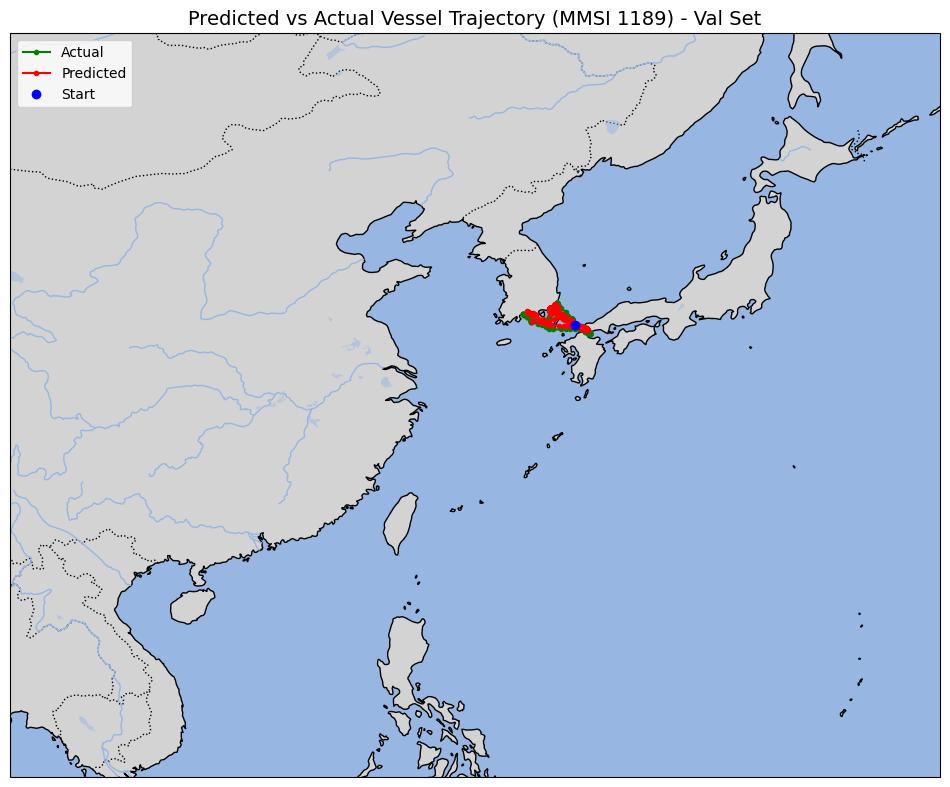

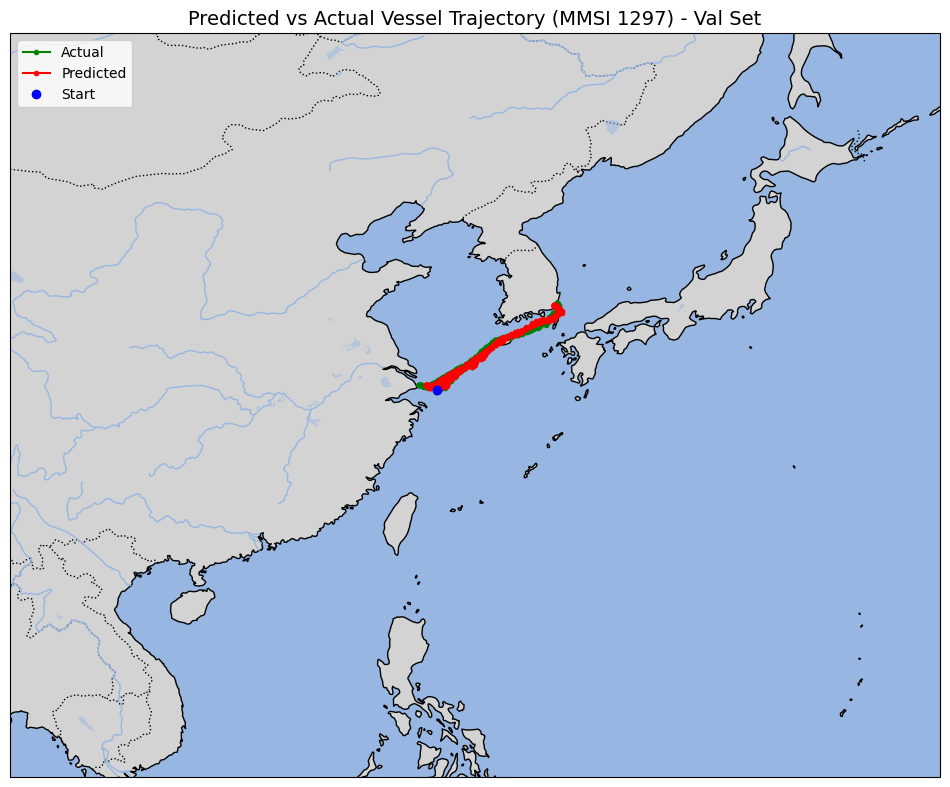

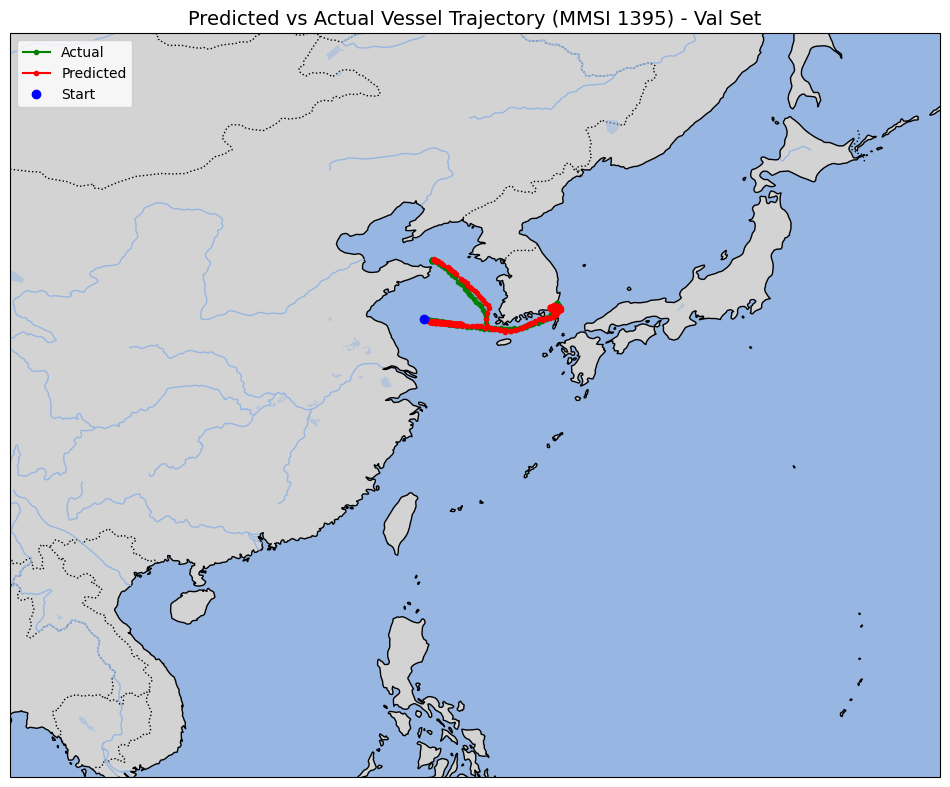

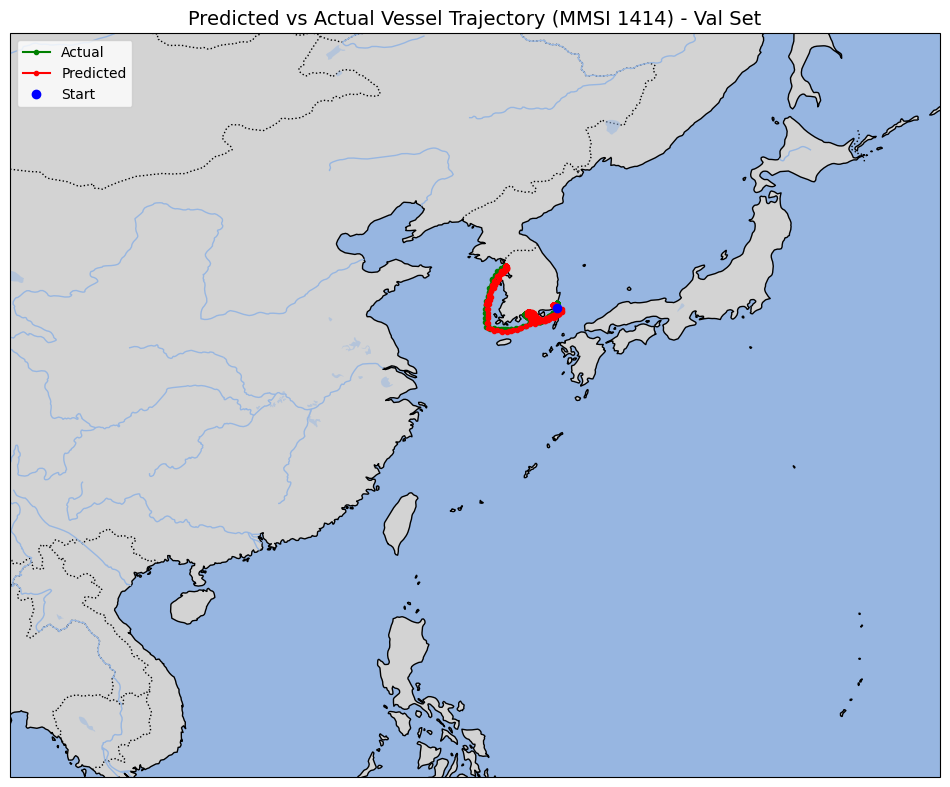

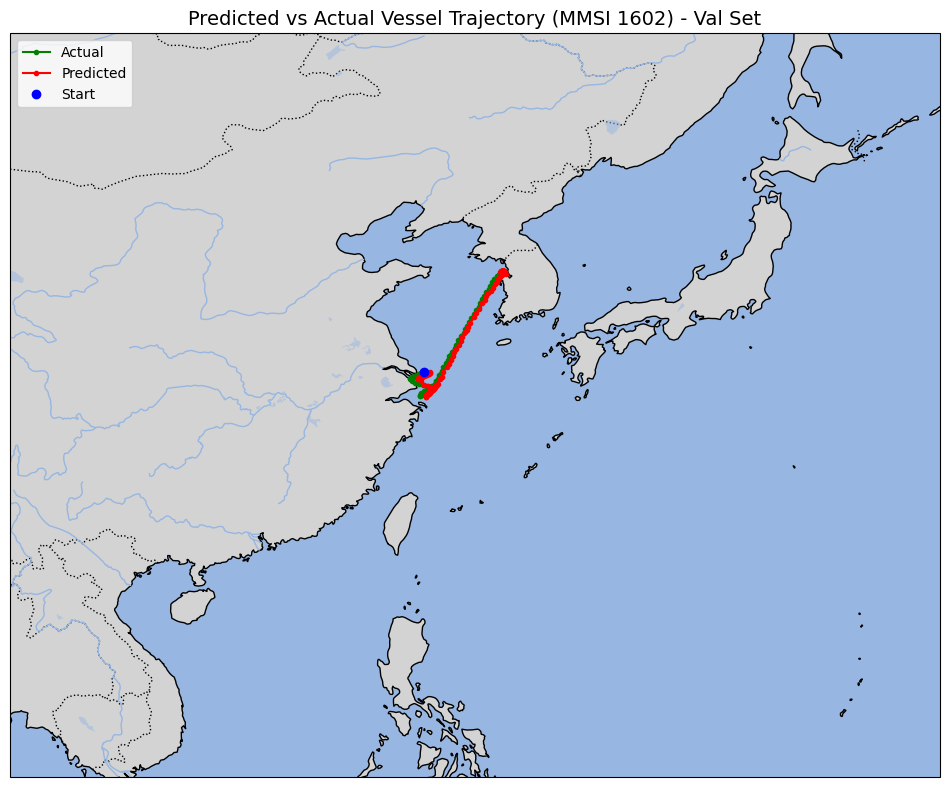

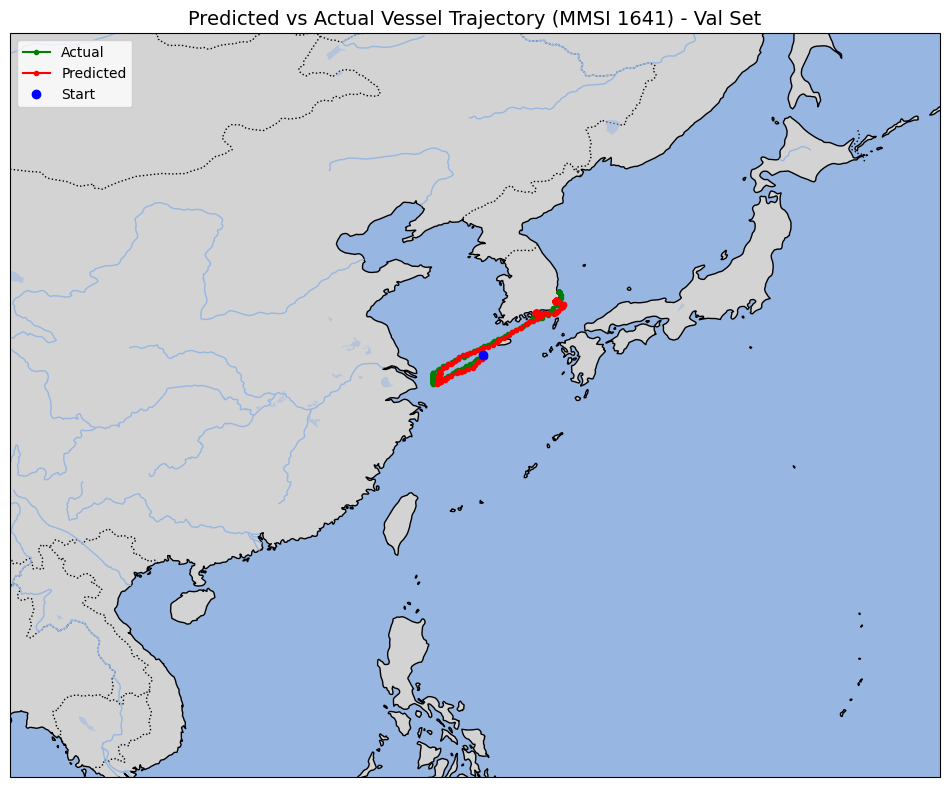

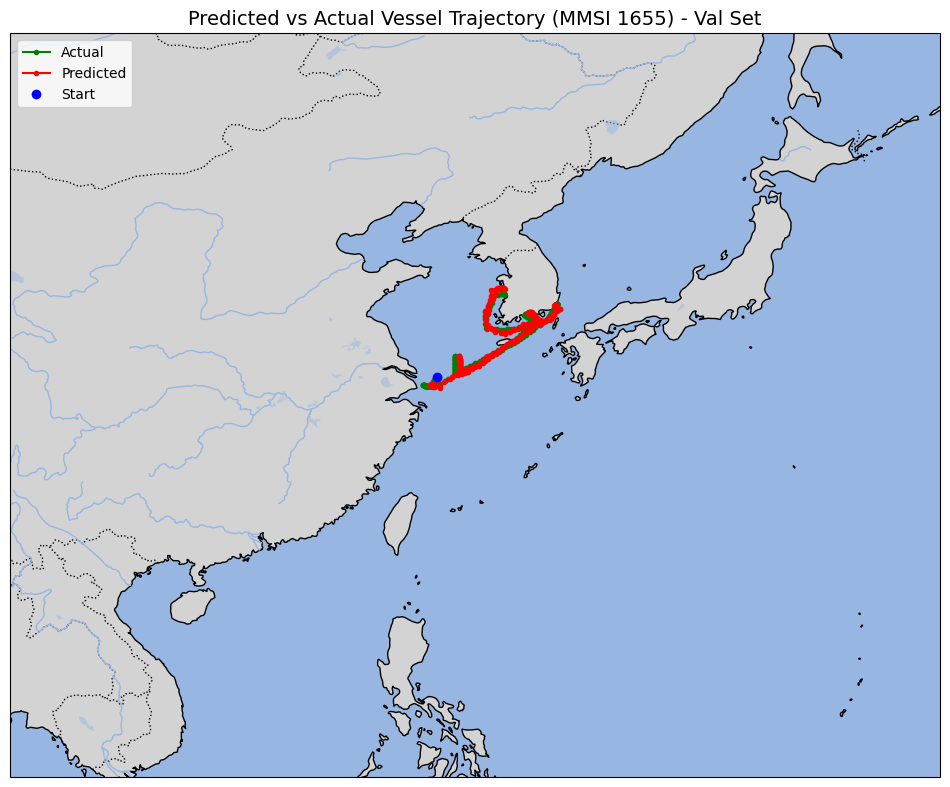

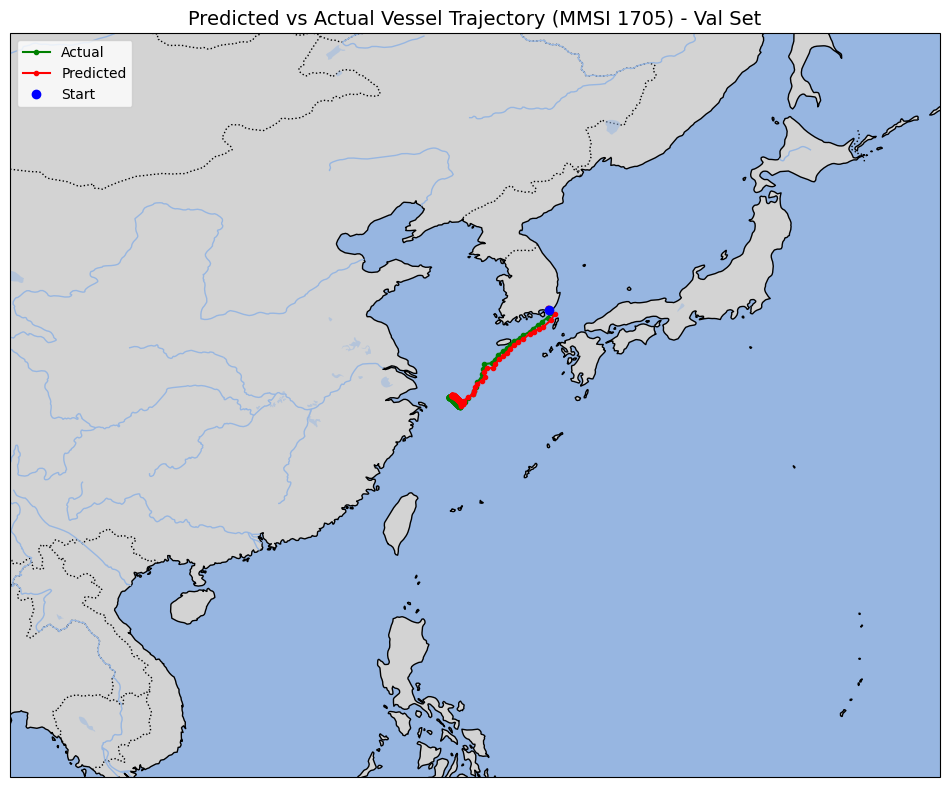

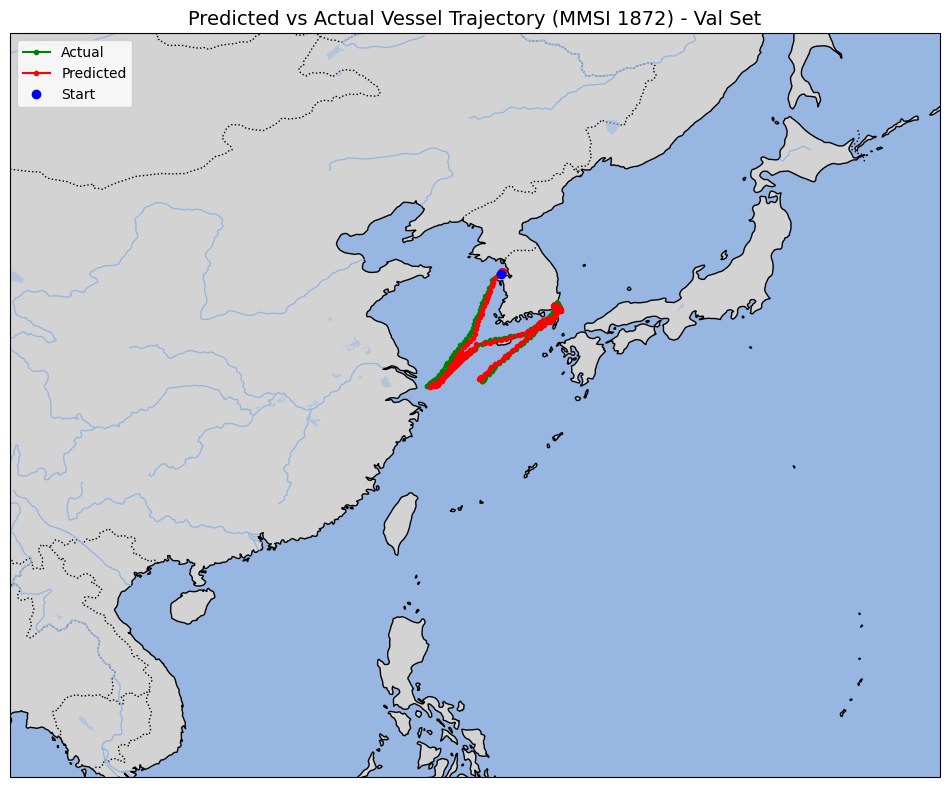

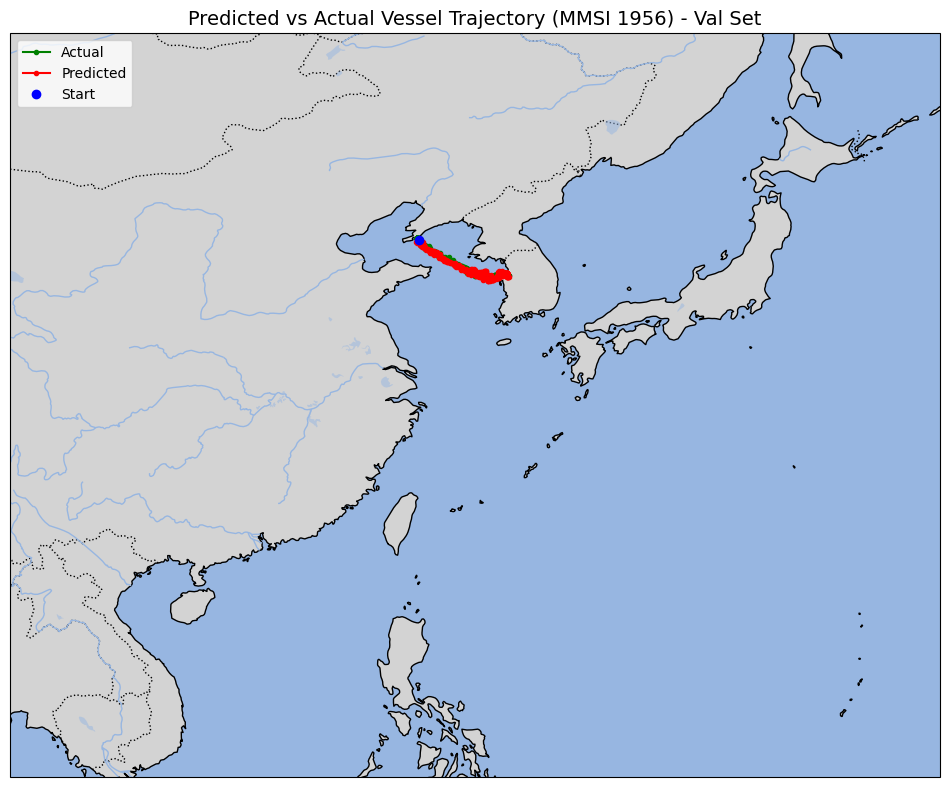

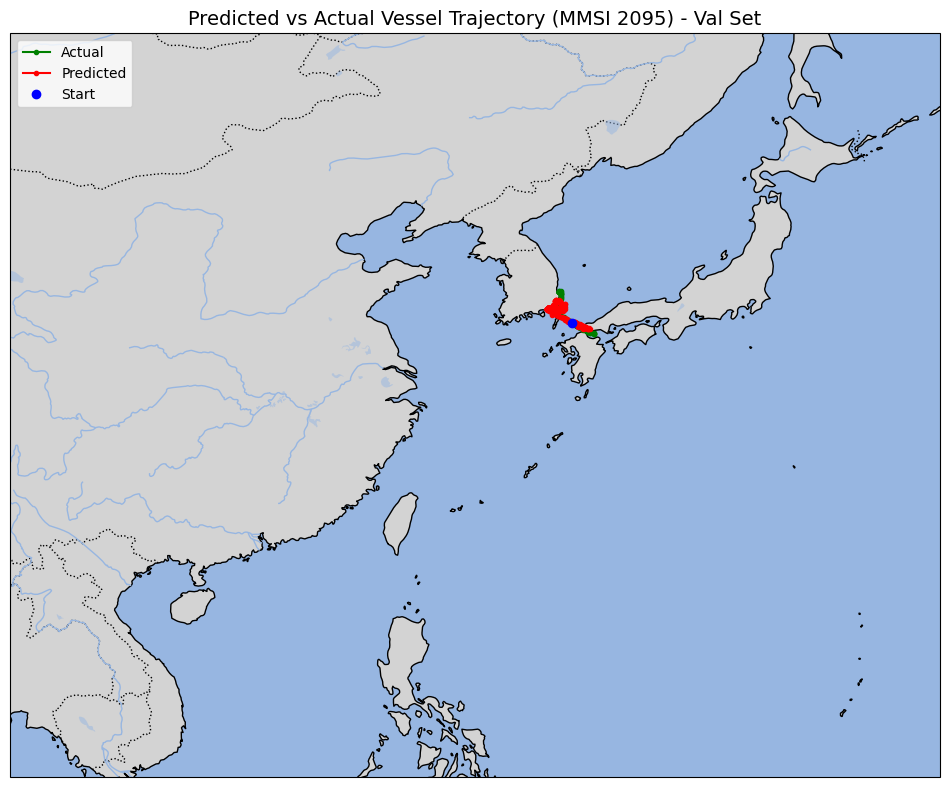

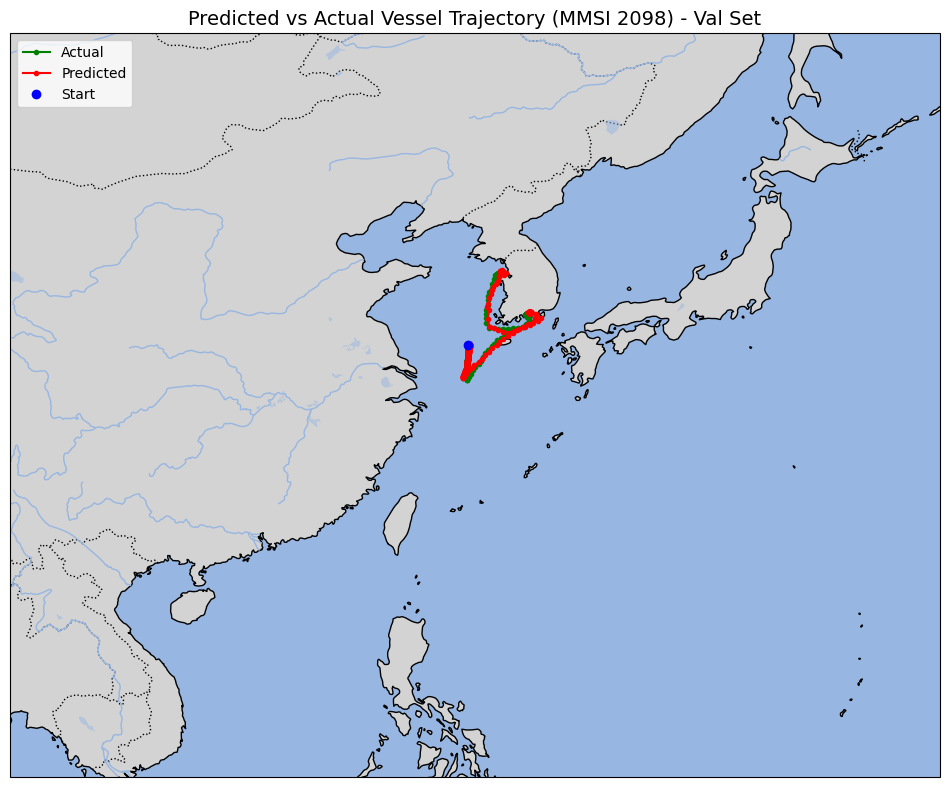

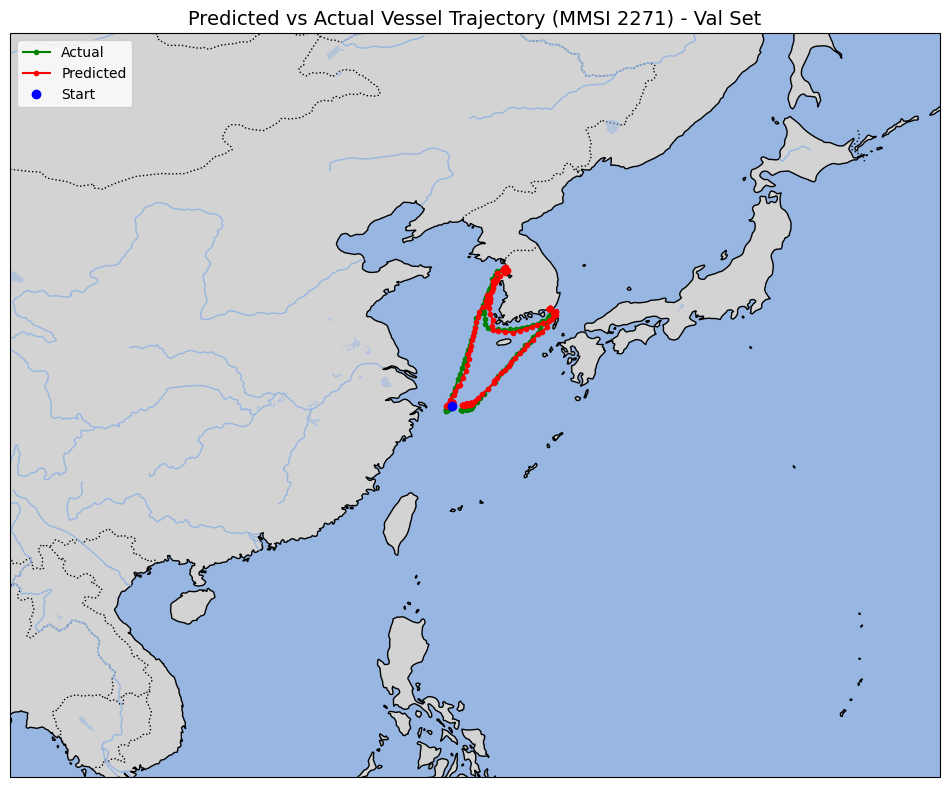

In [40]:
for mmsi in compliant_mmsis:
    plot_on_static_map(
        model=model,
        dataset=final_dataset_scaled,
        mmsi=mmsi,
        input_features=["LAT", "LON", "SPEED", "HEADING"],
        output_features=["LAT", "LON"],
        sequence_length=3,
        set_type="Val",
        scaler=scaler)

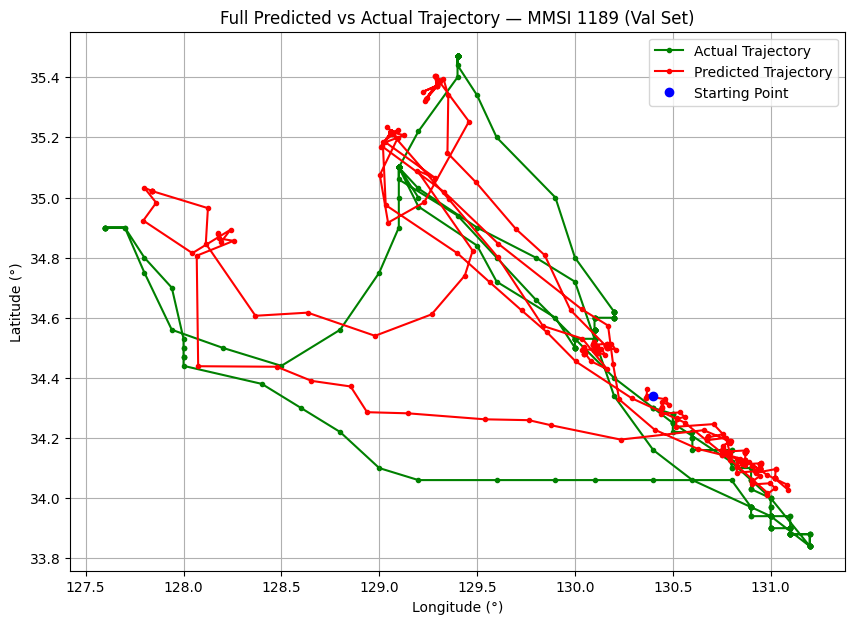

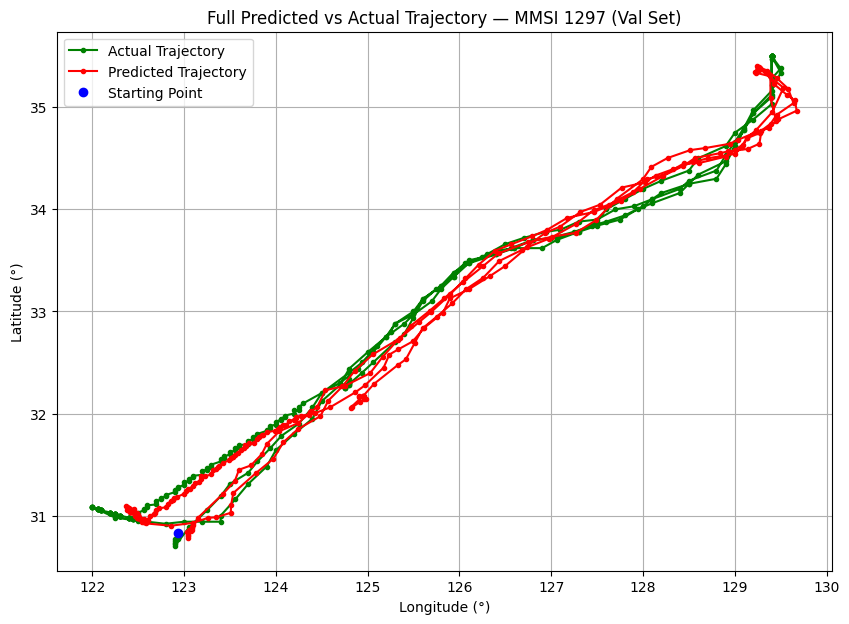

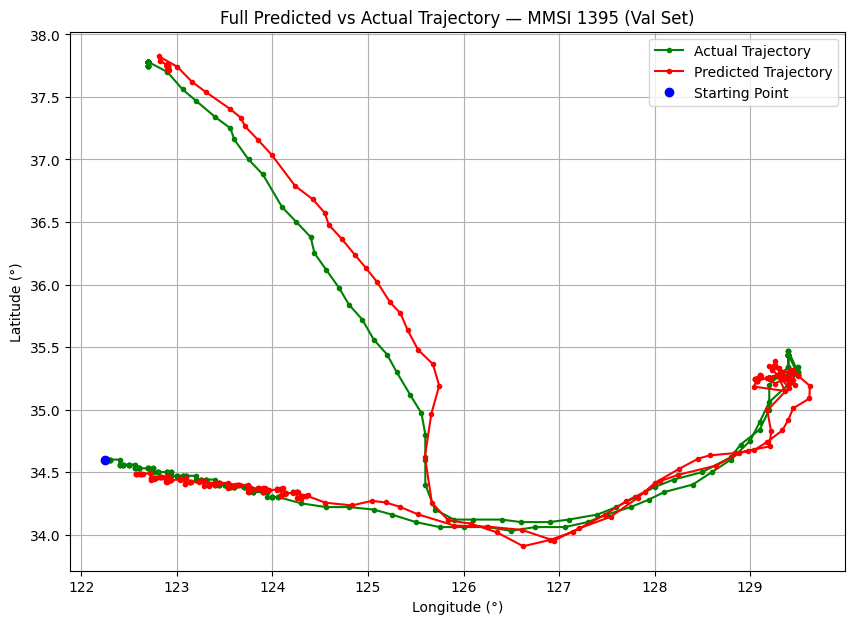

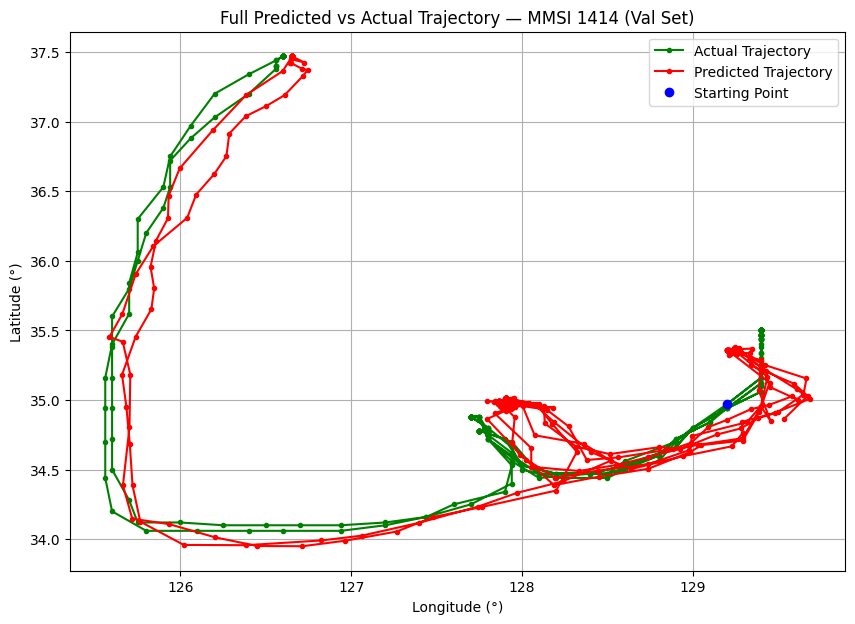

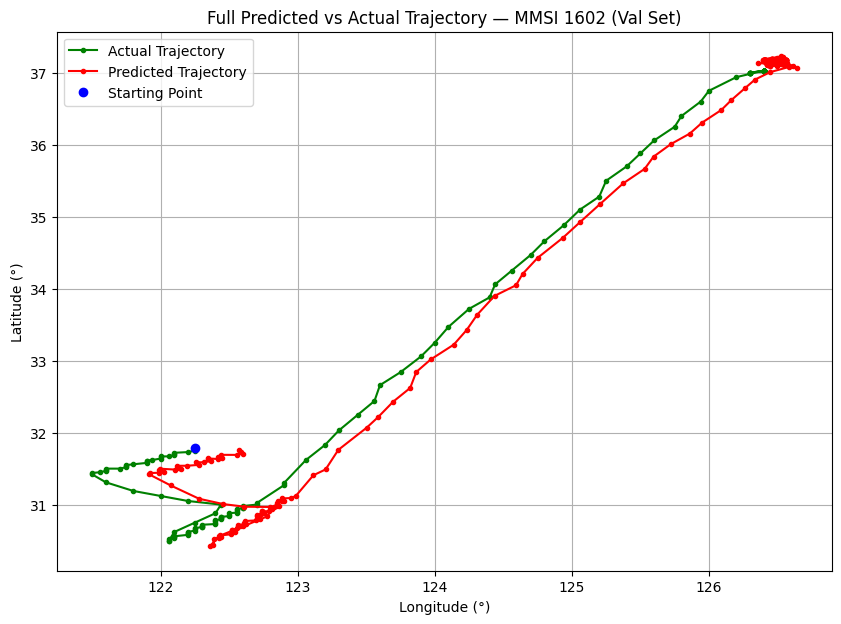

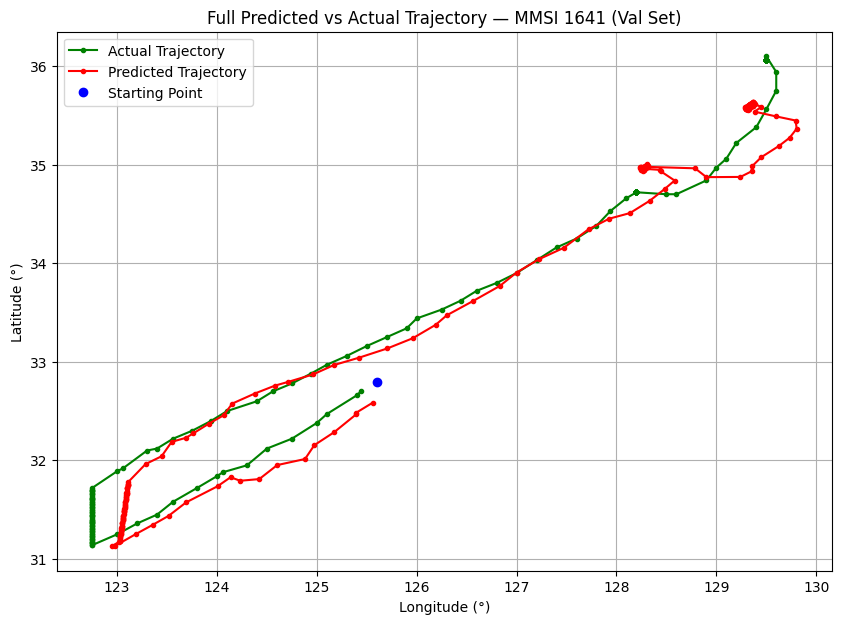

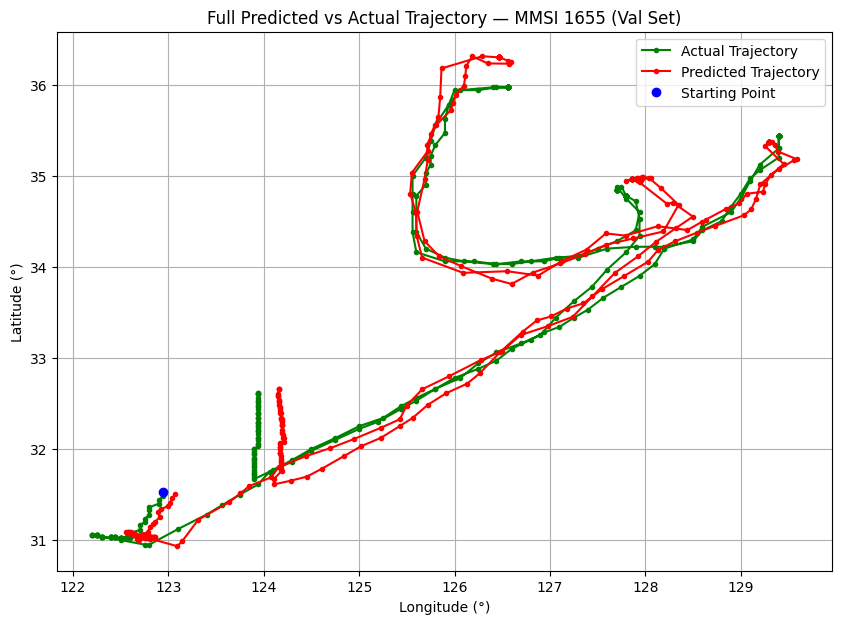

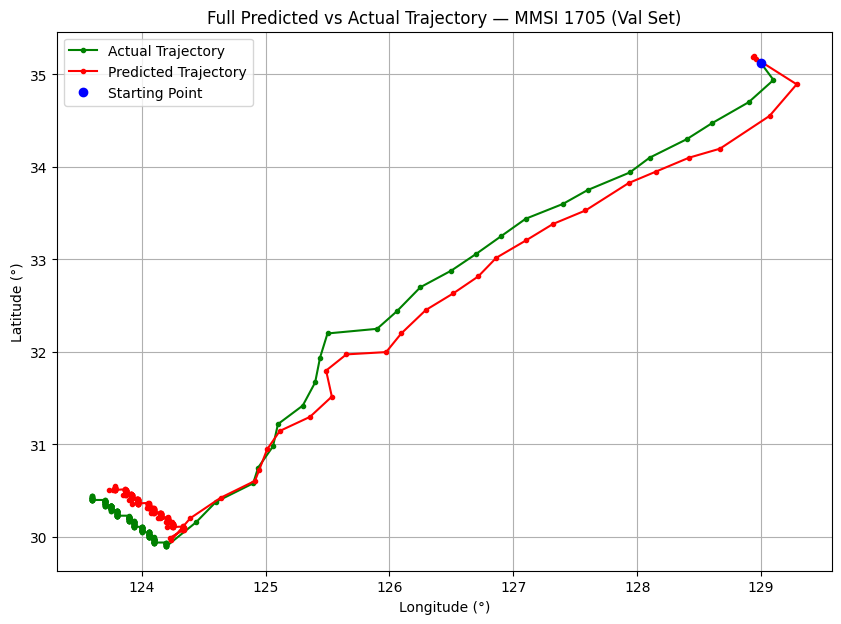

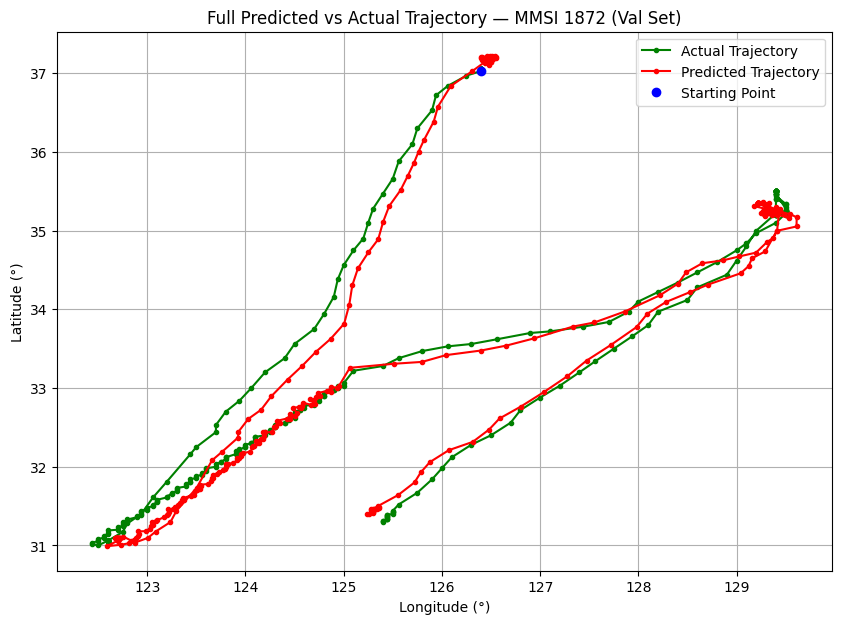

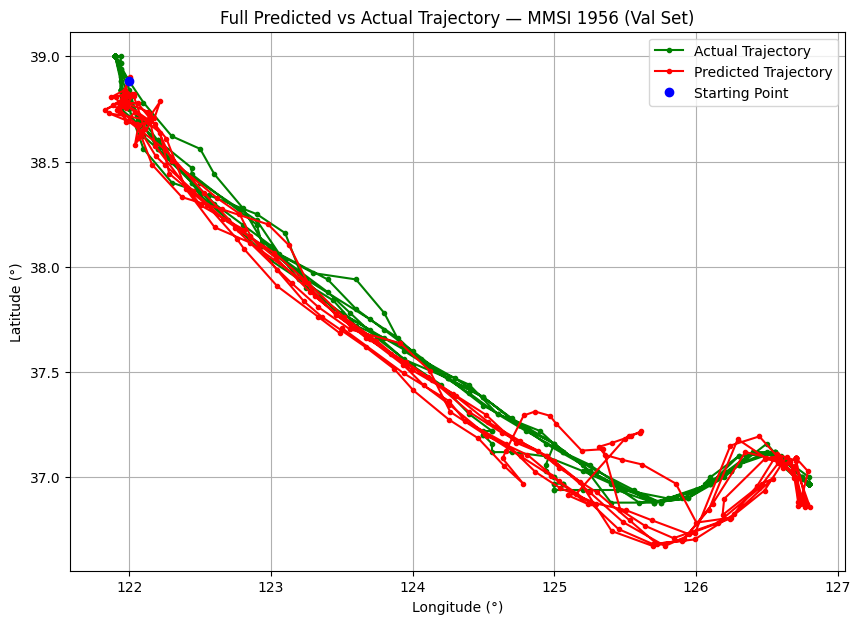

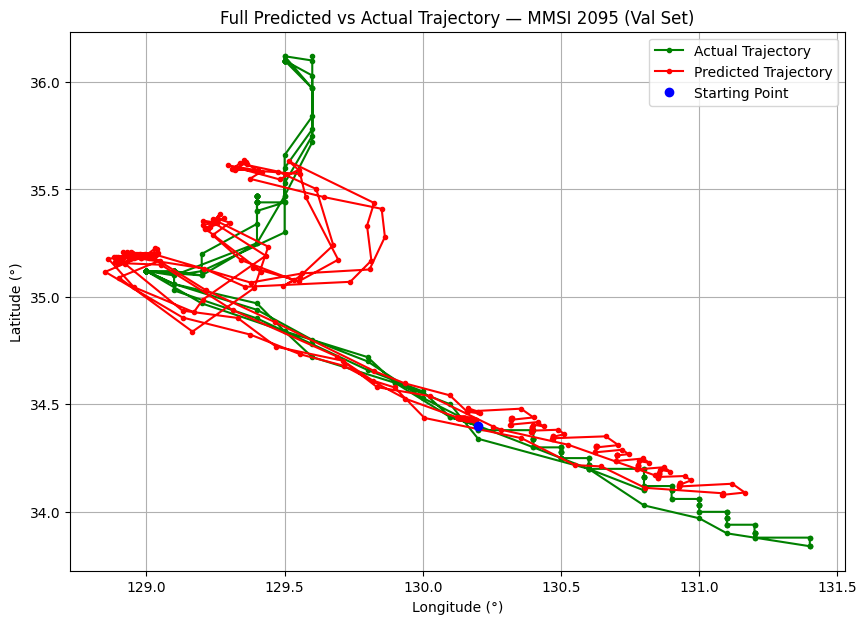

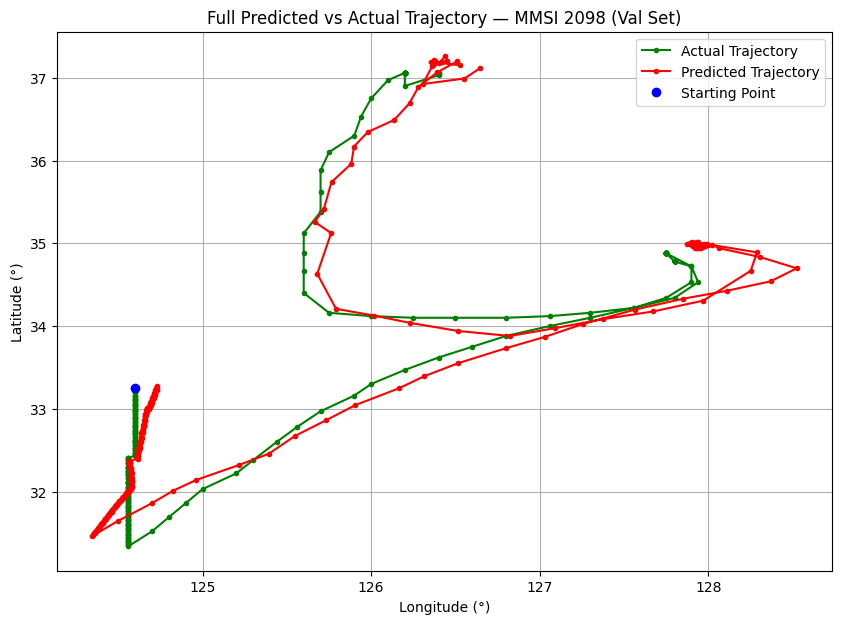

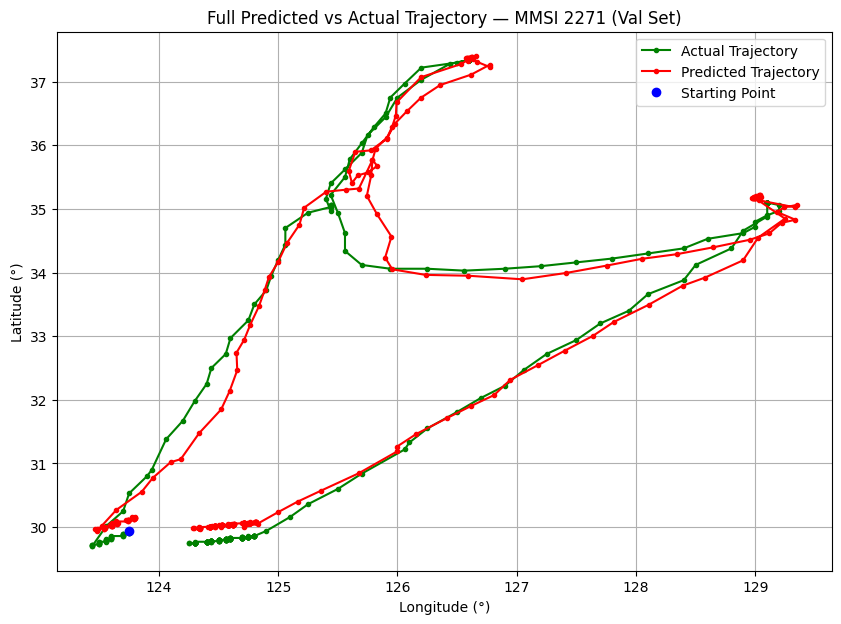

In [41]:
for mmsi in compliant_mmsis:
    plot_full_trajectories(
        model=model,
        dataset=final_dataset_scaled,
        mmsi=mmsi,
        input_features=["LAT", "LON", "SPEED", "HEADING"],
        output_features=["LAT", "LON"],
        sequence_length=3,
        set_type="Val",
        scaler=scaler
 )

In [42]:

# Build the DNN model function
def build_dnn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim), # Use input_dim for 2D input
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(2)  # Predicts next [Latitude, Longitude]
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model



In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
model.fit(
    x=sequences["Train"]["X"],
    y=sequences["Train"]["Y"],
    validation_data=(sequences["Val"]["X"], sequences["Val"]["Y"]),
    epochs=900,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - mae: 0.0255 - val_loss: 3.8503e-04 - val_mae: 0.0159
Epoch 2/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.2249e-04 - mae: 0.0236 - val_loss: 4.2718e-04 - val_mae: 0.0171
Epoch 3/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.1983e-04 - mae: 0.0238 - val_loss: 4.9264e-04 - val_mae: 0.0180
Epoch 4/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0010 - mae: 0.0254 - val_loss: 3.9795e-04 - val_mae: 0.0154
Epoch 5/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010 - mae: 0.0251 - val_loss: 5.2113e-04 - val_mae: 0.0178
Epoch 6/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.8889e-04 - mae: 0.0233 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 7/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.3007e-04 - mae: 0.0227 - val_loss: 6.1993e-04 - val_mae: 0.0193
Epoch 8/900
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.4547e-04 - mae: 0.0238 - val_loss: 0.0010 - val_mae: 0.0263
Epoc

In [44]:

results = []
for mmsi, group in final_dataset_scaled.groupby("MMSI"):
    mmsi_results = {"MMSI": mmsi}
    for split in ["Train", "Val"]:
        subset = group[group["Set"] == split].reset_index(drop=True)
        X_seq, Y_seq = [], []
        for i in range(len(subset) - sequence_length):
            X_seq.append(subset.loc[i:i+sequence_length-1, input_features].values)
            Y_seq.append(subset.loc[i + sequence_length, output_features].values)
        X_seq = np.array(X_seq)
        Y_seq = np.array(Y_seq)
        if len(X_seq) == 0:
            continue
        Y_pred = model.predict(X_seq, verbose=0)
        mae = mean_absolute_error(Y_seq, Y_pred)
        mse = mean_squared_error(Y_seq, Y_pred)
        mmsi_results[f"{split}_MAE"] = mae
        mmsi_results[f"{split}_MSE"] = mse
    results.append(mmsi_results)

metrics_df_dnn = pd.DataFrame(results)
metrics_df_dnn


MMSI  Train_MAE  Train_MSE   Val_MAE   Val_MSE
0   1189   0.010459   0.000171  0.012257  0.000255
1   1297   0.008897   0.000146  0.013181  0.000268
2   1395   0.011342   0.000179  0.011424  0.000168
3   1414   0.011242   0.000194  0.011377  0.000195
4   1602   0.010772   0.000196  0.008553  0.000161
5   1641   0.013378   0.000304  0.023419  0.000932
6   1655   0.010466   0.000196  0.012291  0.000267
7   1705   0.009283   0.000146  0.012894  0.000303
8   1872   0.009405   0.000146  0.009823  0.000184
9   1956   0.013818   0.000276  0.013269  0.000263
10  2095   0.010047   0.000168  0.013358  0.000327
11  2098   0.010381   0.000183  0.012737  0.000252
12  2271   0.009359   0.000153  0.018782  0.000590

In [45]:
def compute_ade_fde_nlade(y_true, y_pred, normalize=False, eps=1e-8):
    if normalize:
        # Compute norms
        true_norms = np.linalg.norm(y_true, axis=1, keepdims=True) + eps
        pred_norms = np.linalg.norm(y_pred, axis=1, keepdims=True) + eps

        # Normalize vectors
        y_true = y_true / true_norms
        y_pred = y_pred / pred_norms

    errors = np.linalg.norm(y_true - y_pred, axis=1)
    ade = np.mean(errors)
    fde = errors[-1] if len(errors) > 0 else np.nan
    return ade, fde


# Prepare result collection
ade_fde_results = []

for mmsi, group in final_dataset_scaled.groupby("MMSI"):
    mmsi_row = {"MMSI": mmsi}

    for split in ["Val", "Test"]:
        subset = group[group["Set"] == split].reset_index(drop=True)
        X_seq, Y_true = [], []

        for i in range(len(subset) - sequence_length):
            X_seq.append(subset.loc[i:i+sequence_length-1, input_features].values)
            Y_true.append(subset.loc[i + sequence_length, output_features].values)

        X_seq = np.array(X_seq)
        Y_true = np.array(Y_true, dtype=np.float32) # Explicitly cast to float32

        if len(X_seq) == 0:
            mmsi_row[f"{split}_ADE"] = np.nan
            mmsi_row[f"{split}_FDE"] = np.nan
            mmsi_row[f"{split}_NL_ADE"] = np.nan
            continue

        Y_pred = model.predict(X_seq, verbose=0)

        ade, fde = compute_ade_fde_nlade(Y_true, Y_pred, normalize=False)
        nl_ade, _ = compute_ade_fde_nlade(Y_true, Y_pred, normalize=True)

        mmsi_row[f"{split}_ADE"] = ade
        mmsi_row[f"{split}_FDE"] = fde
        mmsi_row[f"{split}_NL_ADE"] = nl_ade

    ade_fde_results.append(mmsi_row)

# Convert to DataFrame
ade_fde_df_dnn = pd.DataFrame(ade_fde_results)
print(ade_fde_df_dnn)

    MMSI   Val_ADE   Val_FDE  Val_NL_ADE  Test_ADE  Test_FDE  Test_NL_ADE
0   1189  0.019715  0.023478    0.014694  0.016264  0.034175     0.012858
1   1297  0.021619  0.028573    0.041404  0.020423  0.017385     0.035201
2   1395  0.017124  0.010609    0.019889  0.016548  0.012268     0.010819
3   1414  0.017432  0.023835    0.010069  0.015634  0.036622     0.011069
4   1602  0.015326  0.011155    0.027005  0.012917  0.008224     0.019271
5   1641  0.038201  0.057606    0.030587  0.020746  0.042097     0.034629
6   1655  0.019306  0.001618    0.028344  0.015225  0.009259     0.014363
7   1705  0.023610  0.013826    0.069358  0.013061  0.005340     0.014317
8   1872  0.016344  0.037841    0.019620  0.030550  0.018483     0.069435
9   1956  0.021813  0.024455    0.010686  0.022153  0.037075     0.010523
10  2095  0.021125  0.018999    0.016012  0.021774  0.020004     0.016022
11  2098  0.021074  0.022748    0.029445  0.016756  0.015123     0.017799
12  2271  0.031369  0.039922    0.0834

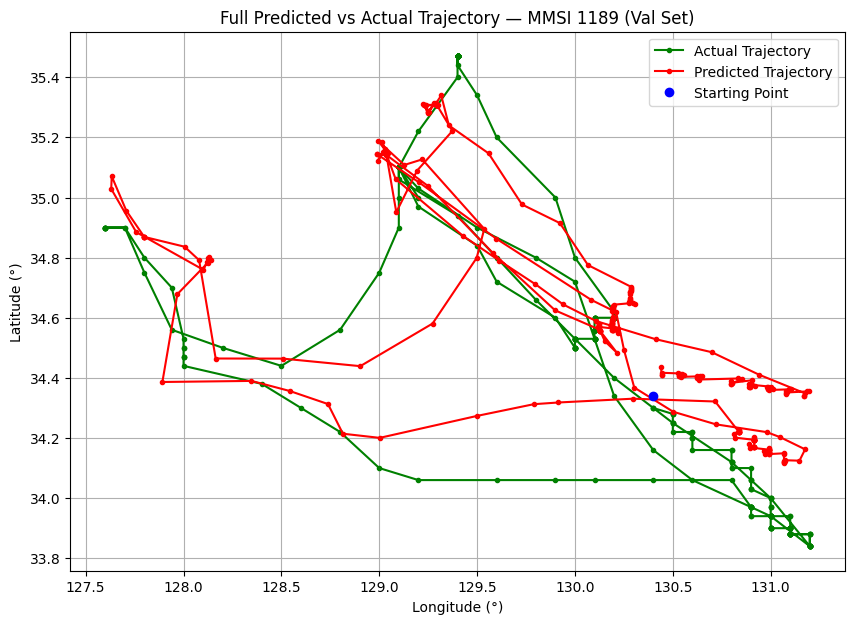

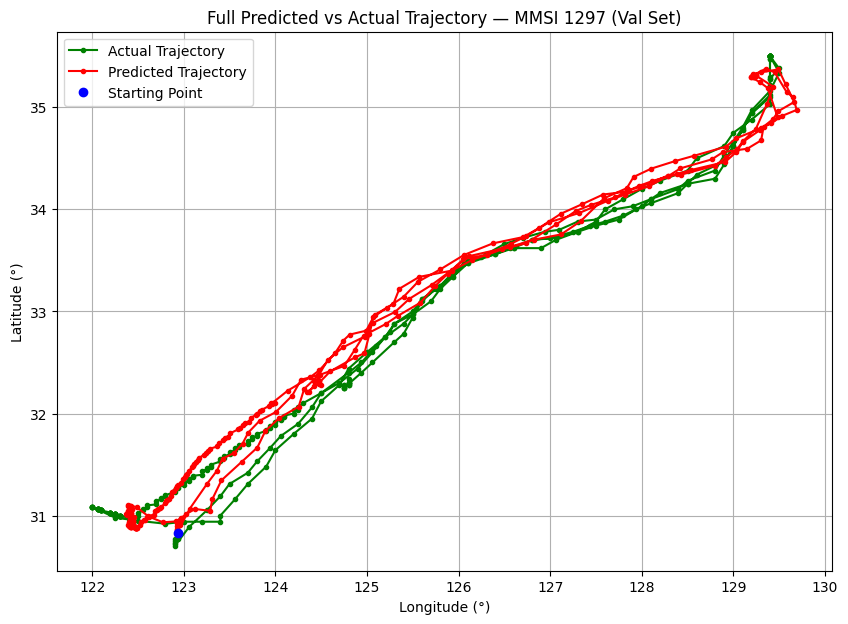

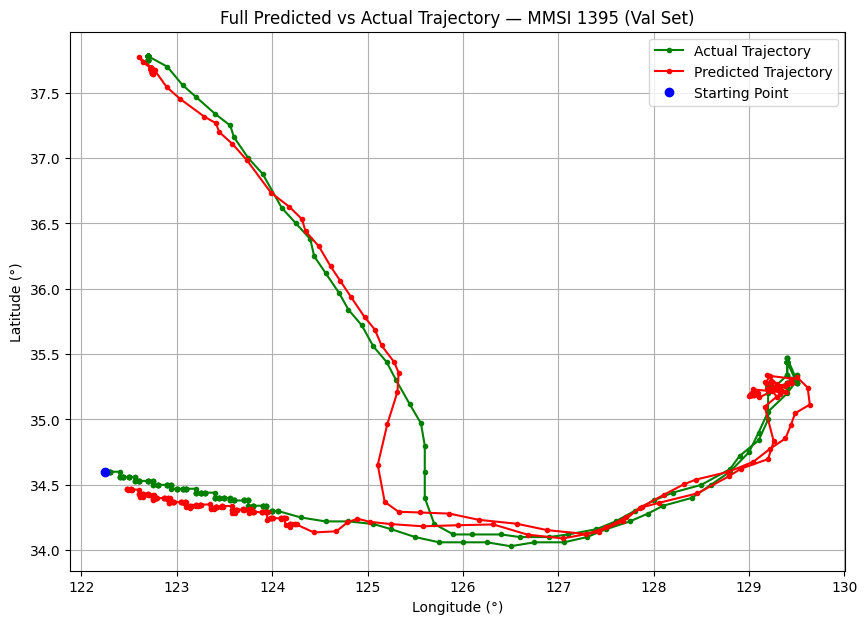

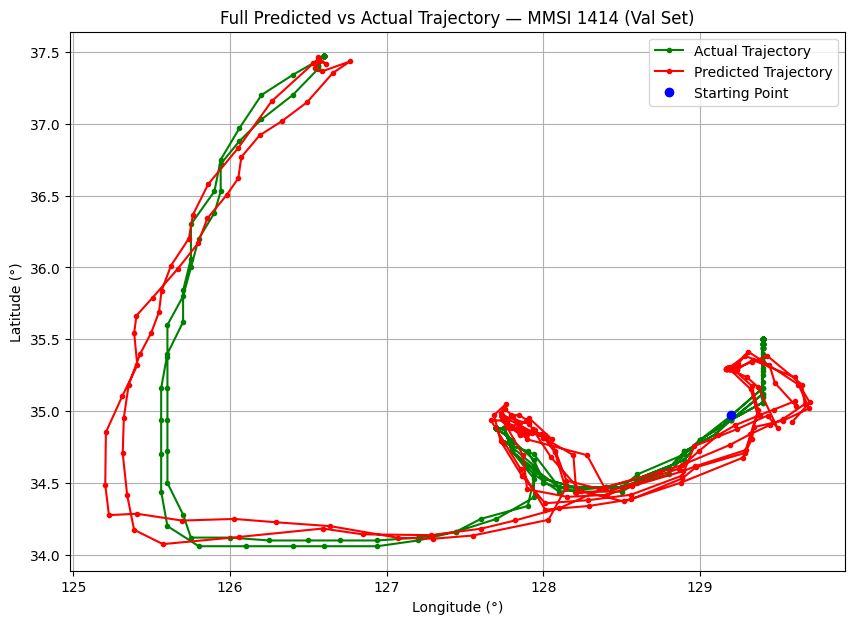

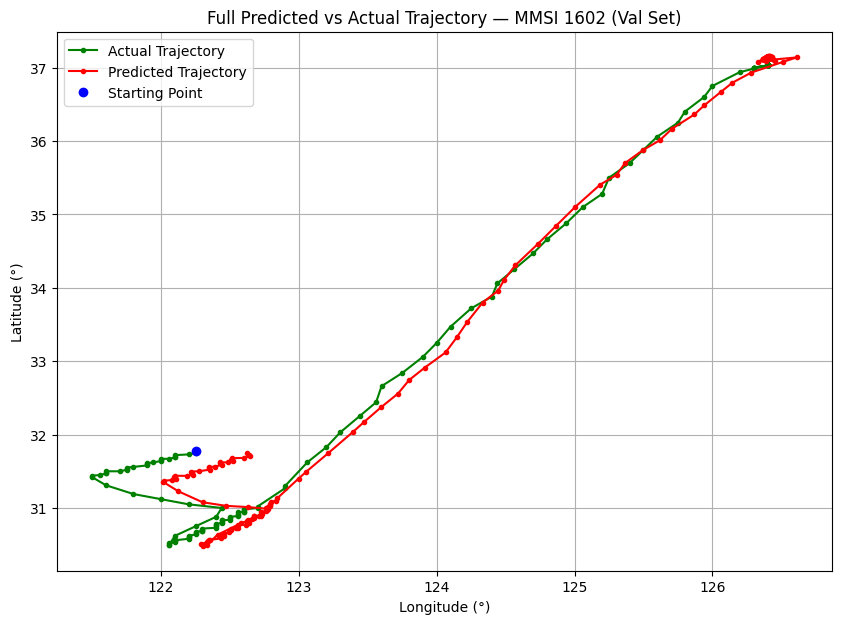

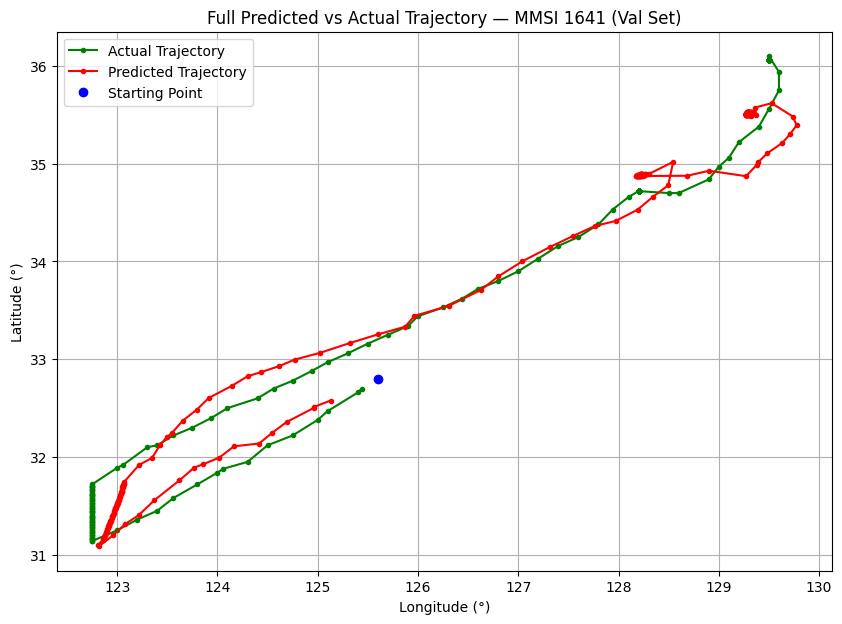

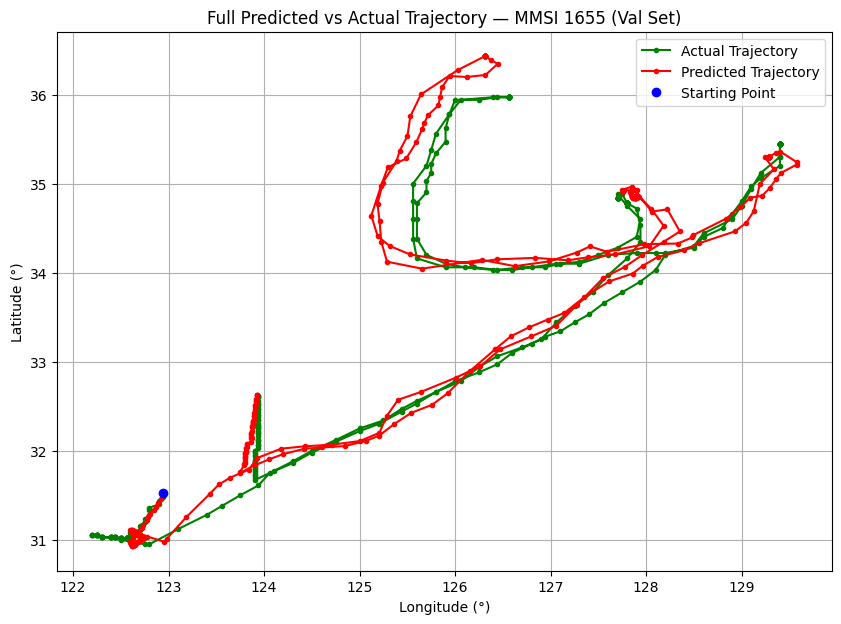

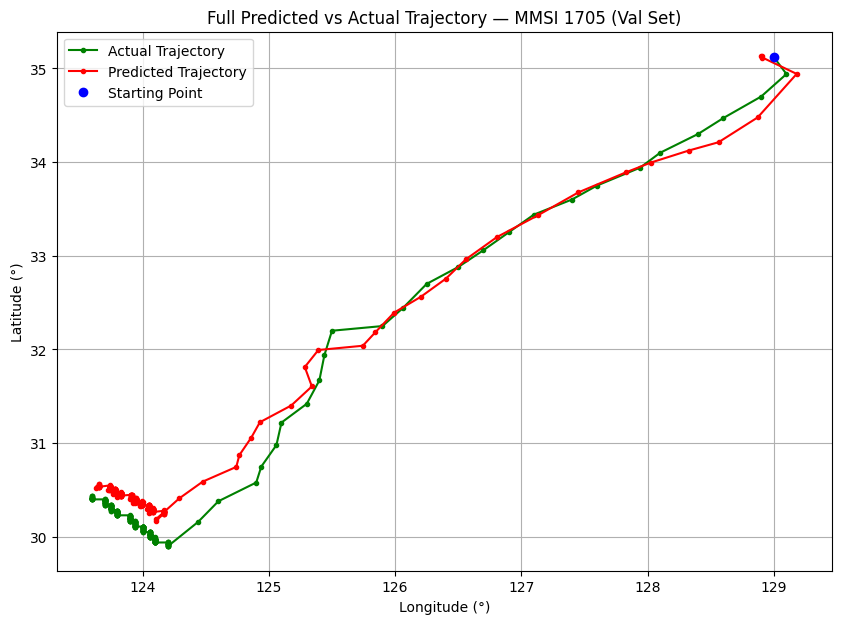

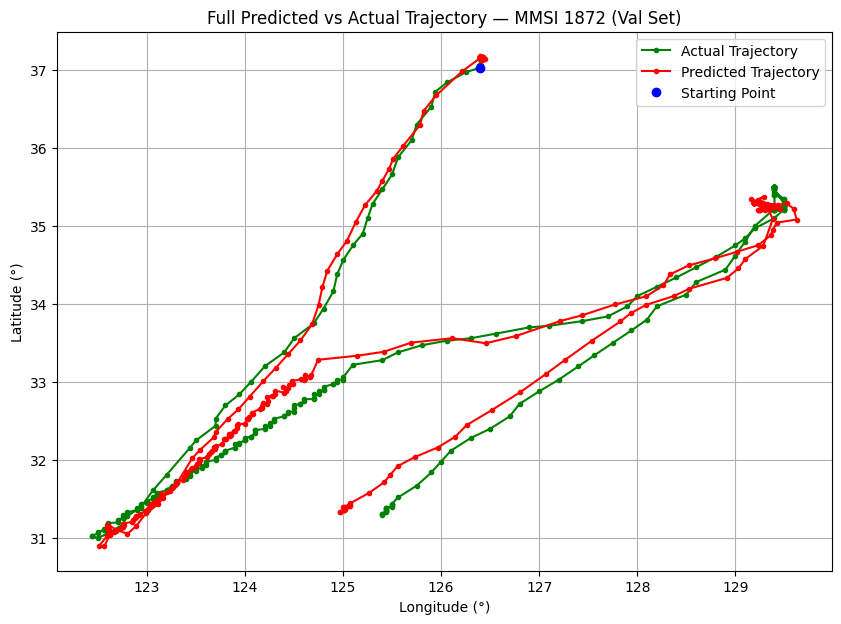

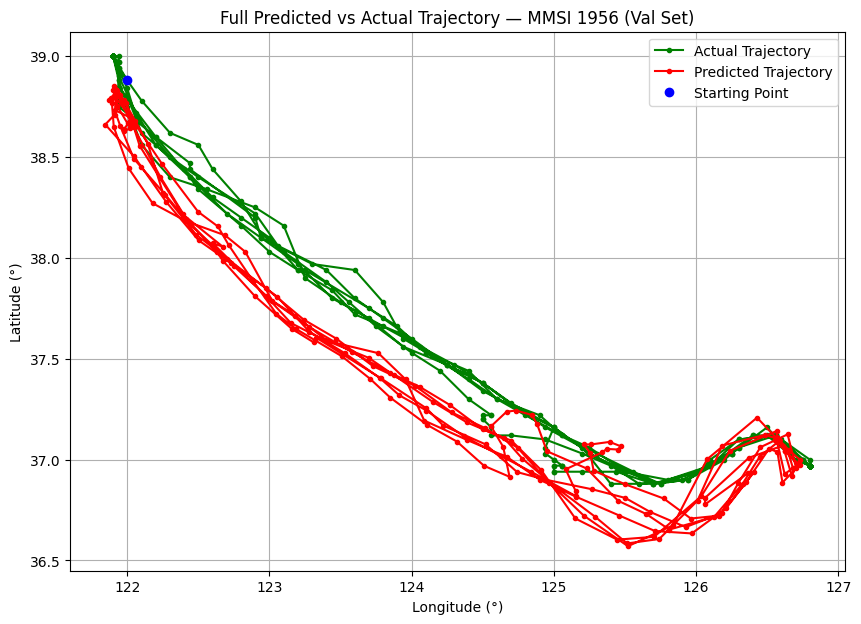

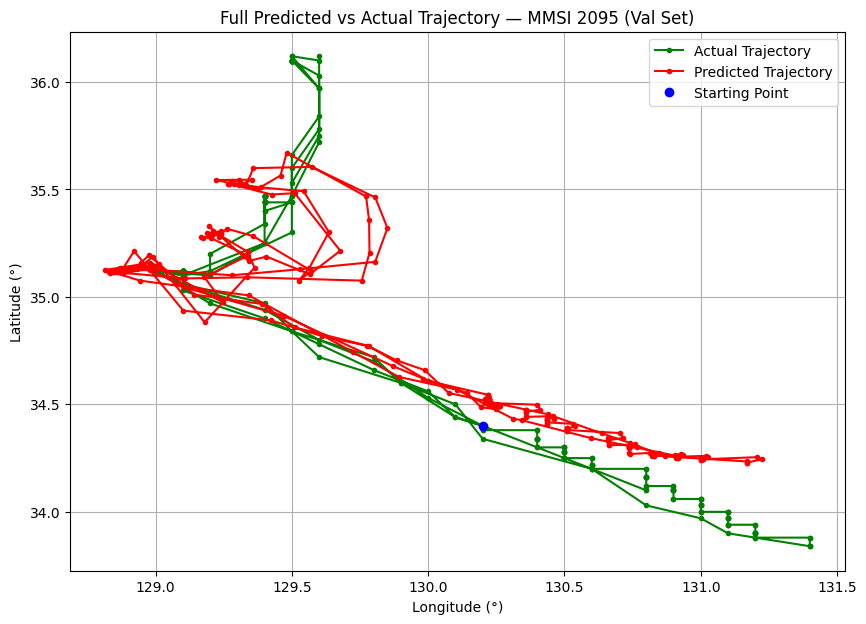

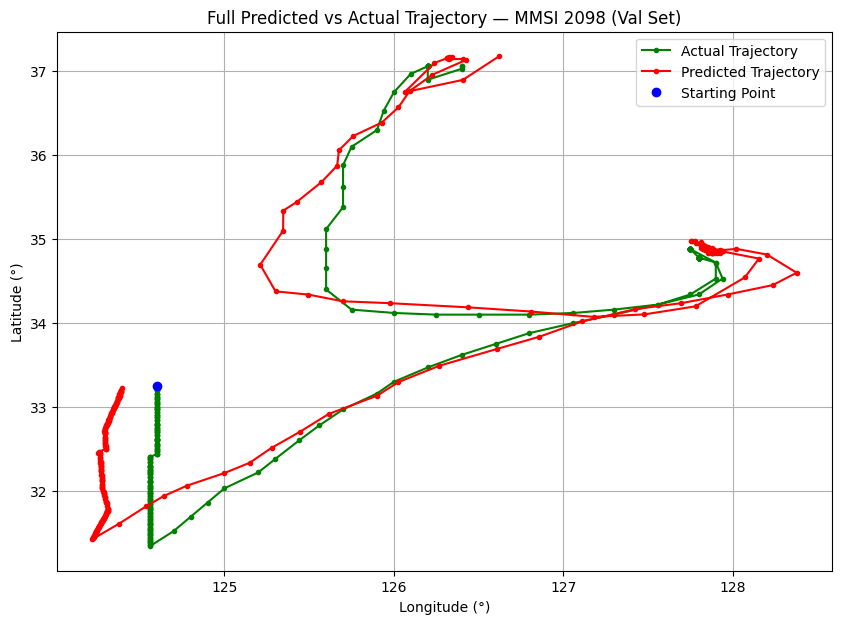

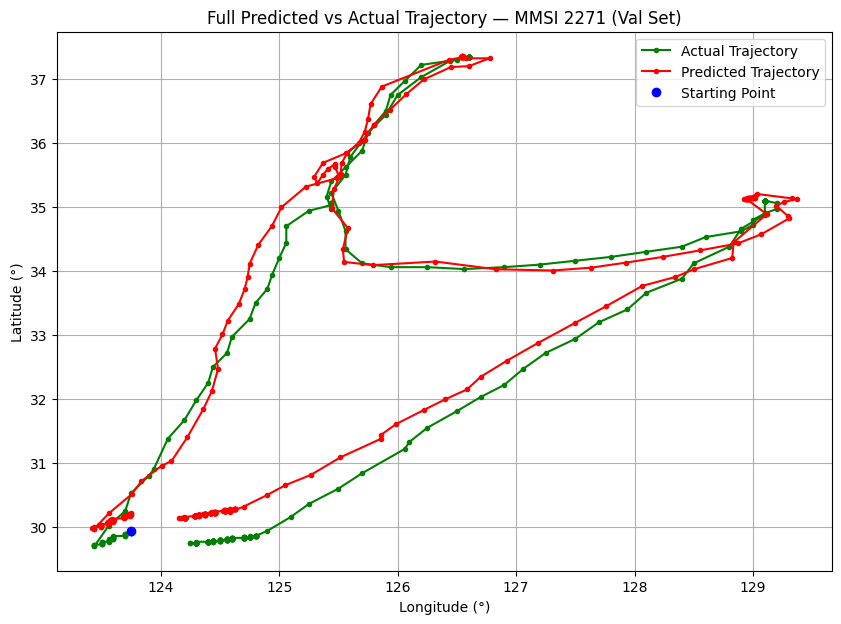

In [46]:
for mmsi in compliant_mmsis:
    plot_full_trajectories(
        model=model,
        dataset=final_dataset_scaled,
        mmsi=mmsi,
        input_features=["LAT", "LON", "SPEED", "HEADING"],
        output_features=["LAT", "LON"],
        sequence_length=3,
        set_type="Val",
        scaler=scaler
    )


In [50]:

# Compute mean Validation MAE and MSE for CNN and DNN
cnn_val_mae = round(metrics_df_cnn["Val_MAE"].mean(), 6)
dnn_val_mae = round(metrics_df_dnn["Val_MAE"].mean(), 6)

cnn_val_mse = round(metrics_df_cnn["Val_MSE"].mean(), 6)
dnn_val_mse = round(metrics_df_dnn["Val_MSE"].mean(), 6)

# Display the results
print("--- Mean Validation Performance ---")
print(f"Validation MAE     | CNN: {cnn_val_mae} | DNN: {dnn_val_mae}")
print(f"Validation MSE     | CNN: {cnn_val_mse} | DNN: {dnn_val_mse}")

--- Mean Validation Performance ---
Validation MAE     | CNN: 0.01325 | DNN: 0.013336
Validation MSE     | CNN: 0.000277 | DNN: 0.00032


In [52]:

# Compute mean Test ADE, FDE, and NL-ADE for CNN and DNN
cnn_test_ade = round(ade_fde_df_cnn["Test_ADE"].mean(), 6)
dnn_test_ade = round(ade_fde_df_dnn["Test_ADE"].mean(), 6)

cnn_test_fde = round(ade_fde_df_cnn["Test_FDE"].mean(), 6)
dnn_test_fde = round(ade_fde_df_dnn["Test_FDE"].mean(), 6)

cnn_test_nlade = round(ade_fde_df_cnn["Test_NL_ADE"].mean(), 6)
dnn_test_nlade = round(ade_fde_df_dnn["Test_NL_ADE"].mean(), 6)

# Display the results
print("--- Mean Test Displacement Metrics ---")
print(f"Test ADE           | CNN: {cnn_test_ade} | DNN: {dnn_test_ade}")
print(f"Test FDE           | CNN: {cnn_test_fde} | DNN: {dnn_test_fde}")
print(f"Test NL-ADE        | CNN: {cnn_test_nlade} | DNN: {dnn_test_nlade}")

--- Mean Test Displacement Metrics ---
Test ADE           | CNN: 0.01980300061404705 | DNN: 0.019308000802993774
Test FDE           | CNN: 0.024869000539183617 | DNN: 0.02085700072348118
Test NL-ADE        | CNN: 0.025405999273061752 | DNN: 0.027752000838518143
